Tutorial 2: Prior Passing
=========================

In the previous tutorial, we used non-linear search chaining to break the model-fitting procedure down into two
non-linear searches. This used an initial search to fit a simple lens model, whose results were used to tune and
initialize the priors of a more complex lens model that was fitted by the second search.

However, the results were passed between searches were passed manually. I explicitly wrote out every result as a prior
containing the values inferred in the first search. **PyAutoLens** has an API for passing priors in a more generalized
way, which is the topic of this tutorial.

In [1]:
%matplotlib inline
from pyprojroot import here
workspace_path = str(here())
%cd $workspace_path
print(f"Working Directory has been set to `{workspace_path}`")

import numpy as np
from os import path
import autolens as al
import autolens.plot as aplt
import autofit as af

/mnt/c/Users/Jammy/Code/PyAuto/autolens_workspace
Working Directory has been set to `/mnt/c/Users/Jammy/Code/PyAuto/autolens_workspace`


__Initial Setup__

we'll use the same strong lensing data as the previous tutorial, where:

 - The lens galaxy's light is an `EllSersic`.
 - The lens galaxy's total mass distribution is an `EllIsothermal` and `ExternalShear`.
 - The source galaxy's `LightProfile` is an `EllExponential`.
 
All the usual steps for setting up a model fit (masking, analysis, etc.) are included below.

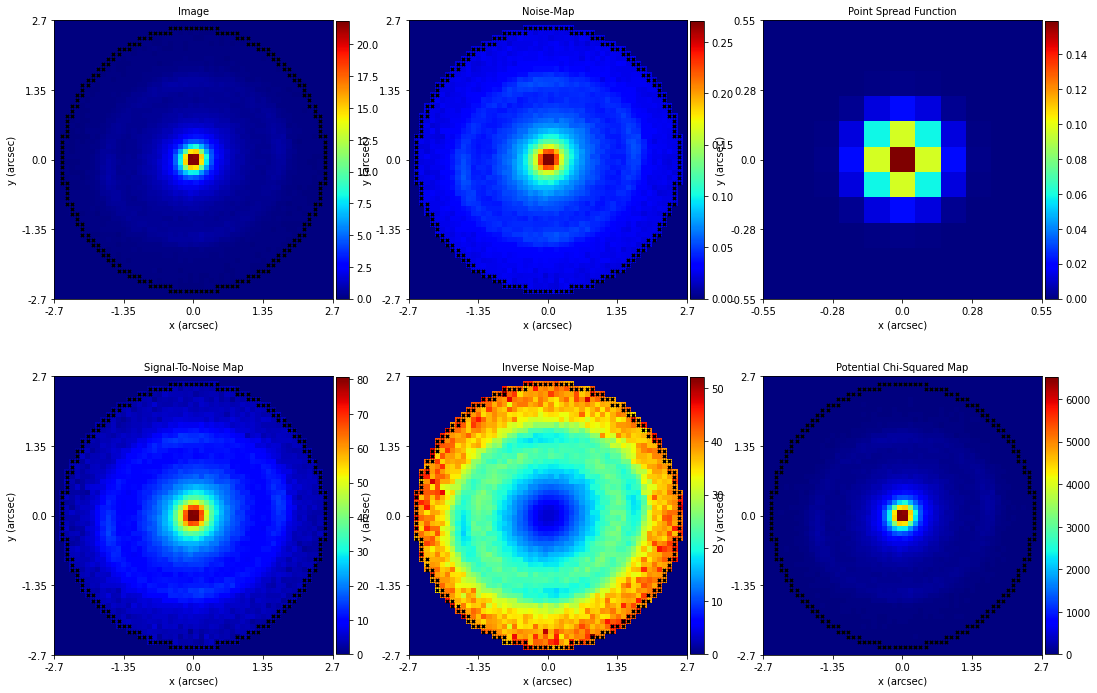

In [2]:
dataset_name = "light_sersic__mass_sie__source_sersic"
dataset_path = path.join("dataset", "imaging", "with_lens_light", dataset_name)

imaging = al.Imaging.from_fits(
    image_path=path.join(dataset_path, "image.fits"),
    noise_map_path=path.join(dataset_path, "noise_map.fits"),
    psf_path=path.join(dataset_path, "psf.fits"),
    pixel_scales=0.1,
)

mask = al.Mask2D.circular(
    shape_native=imaging.shape_native, pixel_scales=imaging.pixel_scales, radius=2.6
)

imaging = imaging.apply_mask(mask=mask)

analysis = al.AnalysisImaging(dataset=imaging)

imaging_plotter = aplt.ImagingPlotter(
    imaging=imaging, visuals_2d=aplt.Visuals2D(mask=mask)
)
imaging_plotter.subplot_imaging()

__Model__

We are going to use the same result of search 1 from the previous tutorial. Thus, we set up an identical model such 
that we instantly load the result from hard-disk.

In [3]:
bulge = af.Model(al.lp.EllSersic)
mass = af.Model(al.mp.EllIsothermal)

bulge.centre_0 = 0.0
bulge.centre_1 = 0.0
mass.centre_0 = 0.0
mass.centre_1 = 0.0

mass.elliptical_comps = bulge.elliptical_comps

bulge.sersic_index = 4.0

lens = af.Model(
    al.Galaxy, redshift=0.5, bulge=bulge, mass=mass, shear=al.mp.ExternalShear
)

source = af.Model(al.Galaxy, redshift=1.0, bulge=al.lp.EllExponential)

model = af.Collection(galaxies=af.Collection(lens=lens, source=source))

__Search__

We also create the same search as the previous tutorial, using the same name to ensure we use the same results, and 
run it.

In [4]:
search = af.DynestyStatic(
    path_prefix=path.join("howtolens", "chapter_3"),
    name="tutorial_1_search_chaining_1",
    n_live_points=50,
)

result_1 = search.fit(model=model, analysis=analysis)

INFO:root:tutorial_1_search_chaining_1 already completed, skipping non-linear search.


__Prior Passing__

We are now going to use the prior passing API to pass these results, in a way which does not require us to manually 
write out the inferred parameter values of each component. The details of how prior passing is performed will be 
expanded upon at the end of the tutorial.

We start with the lens's bulge, which in the previous search was an `EllSersic` with its centre fixed to (0.0, 0.0) 
and its `sersic_index` fixed to 4.0. The API for passing priors is shown below and there are two things worth noting:

 1) We pass the priors using the `model` attribute of the result. This informs **PyAutoLens** to pass the result as a
 model component that is to be fitted for in the next search, using priors that are initialized from the previous
 search's result. Note, if we pass as a `model` a parameter that was fixed in search 1 (e.g. the `sersic_index`) it 
 will be fixed to the same value in search 2.

 2) We do not pass the `centre` or `sersic_index` using `model`, because it would be fixed to the values that it was in 
 the first search. By omitting the centre, it uses the default priors on a lens galaxy, whereas we manually tell the 
 Sersic index to use a `GaussianPrior` centred on 4.0. 

In [5]:
bulge = af.Model(al.lp.EllSersic)

bulge.elliptical_comps = result_1.model.galaxies.lens.bulge.elliptical_comps
bulge.intensity = result_1.model.galaxies.lens.bulge.intensity
bulge.effective_radius = result_1.model.galaxies.lens.bulge.effective_radius
bulge.sersic_index = af.GaussianPrior(
    mean=4.0, sigma=2.0, lower_limit=0.0, upper_limit=5.0
)

For the mass, we again must account for how its centre was fixed to (0.0", 0.0") and therefore not pass the centre.
Passing the other parameters is the same as how we passed the bulge parameters, as is the shear.

In [6]:
mass = af.Model(al.mp.EllIsothermal)
mass.einstein_radius = result_1.model.galaxies.lens.mass.einstein_radius
mass.elliptical_comps = result_1.model.galaxies.lens.mass.elliptical_comps
shear = result_1.model.galaxies.lens.shear

For the source's bulge, we are passing the result of an `EllExponential` to an `EllSersic`. 

We can use a special prior passing method to do this, called `take_attributes`. This scans the `EllExponential`
passed to the `take_attributes` method for all parameters which have the same name as the `EllSersic` model,
and if their names are the same it passes their prior as a `model` (like we did above). Thus, it will locate all 6
parameters in common between the two profiles (centre_, elliptical_comps, intensity, effective_radius) and pass those,
leaving the `sersic_index`'s priors as the default values.

The `take_attributes` method is used in many examples of prior passing, when we pass a simpler parameterization of a
model to a more complex model. Another good example would be passing the result of a `SphIsothermal` to an
`EllIsothermal`.

In [7]:
source_bulge = af.Model(al.lp.EllSersic)
source_bulge.take_attributes(result_1.model.galaxies.source.bulge)

We now compose the model with these components that have had their priors customized. 

In [8]:
lens = af.Model(al.Galaxy, redshift=0.5, bulge=bulge, mass=mass, shear=shear)

source = af.Model(al.Galaxy, redshift=1.0, bulge=source_bulge)

model = af.Collection(galaxies=af.Collection(lens=lens, source=source))

__Search__

Lets setup and run the search. I have given it a different name to the previous tutorial so we can compare the priors
that were passed.

In [9]:
search = af.DynestyStatic(
    path_prefix=path.join("howtolens", "chapter_3"),
    name="tutorial_2_search_chaining_2",
    n_live_points=50,
)

print(
    "Dynesty has begun running - checkout the workspace/output/5_chaining_searches"
    " folder for live output of the results, images and lens model."
    " This Jupyter notebook cell with progress once Dynesty has completed - this could take some time!"
)

result_2 = search.fit(model=model, analysis=analysis)

print("Dynesty has finished run - you may now continue the notebook.")

INFO:root:tutorial_2_search_chaining_2 already completed, skipping non-linear search.


Dynesty has begun running - checkout the workspace/output/5_chaining_searches folder for live output of the results, images and lens model. This Jupyter notebook cell with progress once Dynesty has completed - this could take some time!
Dynesty has finished run - you may now continue the notebook.


__Result__

Look at that, the right lens model, again!

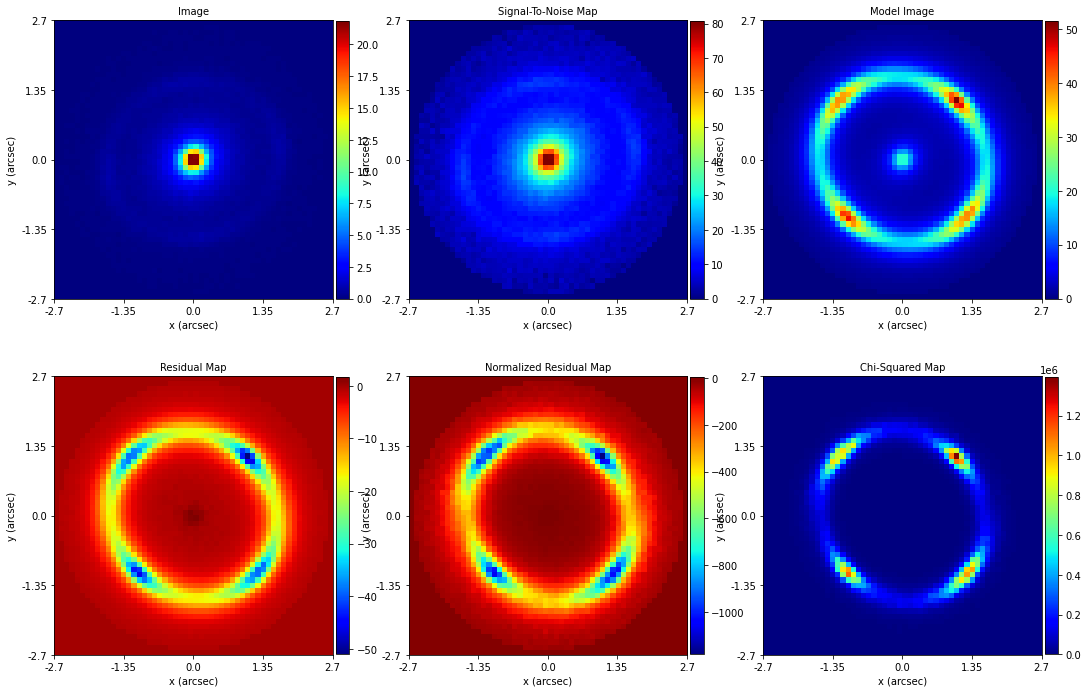

In [10]:
fit_imaging_plotter = aplt.FitImagingPlotter(fit=result_2.max_log_likelihood_fit)
fit_imaging_plotter.subplot_fit_imaging()

__Wrap Up__

We will expand on the prior passing API in the following tutorials. The main thing to note is that we can pass 
entire profiles or galaxies using prior passing, if their model does not change (which for the bulge, mass and 
source_bulge above, was not true). The API to pass a whole profile or galaxy is as follows:
 
 bulge = result_1.model.galaxies.lens.bulge
 lens = result_1.model.galaxies.lens
 source = result_1.model.galaxies.source
 
We can also pass priors using an `instance` instead of a `model`. When an `instance` is used, the maximum likelihood
parameter values are passed as fixed values that are therefore not fitted for nby the non-linear search (reducing its
dimensionality). We will use this in the next tutorial to fit the lens light, fix it to the best-fit model in a second
search, and then go on to fit it as a model in the final search.
 
Lets now think about how priors are passed. Checkout the `model.info` file of the second search of this tutorial. The 
parameters do not use the default priors we saw in search 1 (which are typically broad UniformPriors). Instead, 
they use GaussianPrior`s where:

 - The mean values are the median PDF results of every parameter in search 1.
 - Some sigma values are the errors computed at 3.0 sigma confidence of every parameter in search 1.
 - Other sigma values are higher than the errors computed at 3.0 sigma confidence. These instead use the value 
 specified in the `width_modifier` field of the `Profile`'s entry in the `priors` '.json' config files (we will discuss
 why this is used in a moment).

Thus, like the manual `GaussianPrior`'s that were used in tutorial 1, the prior passing API sets up the prior on each 
parameter with a `GaussianPrior` centred on the high likelihood regions of parameter space!

In [11]:

# %%
'''
__Detailed Explanation Of Prior Passing__

To end, I provide a detailed overview of how prior passing works and illustrate tools that can be used to customize
its behaviour. It is up to you whether you want read this, or go ahead to the next tutorial!

Lets say I chain two parameters as follows:
 
 ```
 mass.einstein_radius = result_1.model.galaxies.lens.mass.einstein_radius
```

By invoking the `model` attribute, the prior is passed following 3 rules:

 1) The new parameter, in this case the einstein radius, uses a `GaussianPrior`. A `GaussianPrior` is ideal, as the 1D 
 pdf results we compute at the end of a search are easily summarized as a Gaussian.

 2) The mean of the `GaussianPrior` is the median PDF value of the parameter estimated in search 1.
    
 This ensures that the initial sampling of the new search's non-linear starts by searching the region of non-linear 
 parameter space that correspond to highest log likelihood solutions in the previous search. Thus, we're setting 
 our priors to look in the `correct` regions of parameter space.

 3) The sigma of the Gaussian will use the maximum of two values: 
   
 (i) the 1D error of the parameter computed at an input sigma value (default sigma=3.0).
 
 (ii) The value specified for the profile in the `config/priors/*.json` config file's `width_modifer` 
 field (check these files out now).

The idea here is simple. We want a value of sigma that gives a `GaussianPrior` wide enough to search a broad 
region of parameter space, so that the lens model can change if a better solution is nearby. However, we want it 
to be narrow enough that we don't search too much of parameter space, as this will be slow or risk leading us 
into an incorrect solution! A natural choice is the errors of the parameter from the previous search.
       
Unfortunately, this doesn't always work. Lens modeling is prone to an effect called `over-fitting` where the errors on 
the lens model parameters is underestimated. This is especially true when we take the shortcuts in early searches, e.g. 
fast non-linear search settings, fitting simplified lens models, etc.
    
Therefore, the `width_modifier` in the `priors/*.json` config files are our fallback. If the error on a parameter is 
suspiciously small, we instead use the value specified in the widths file. These values are chosen based on our 
experience as being a good balance broadly sampling parameter space but not being so narrow important solutions 
are missed. 
       
There are two ways a value is specified using the priors/width file:

 1) Absolute: In this case, the error assumed on the parameter is the value given in the config file. 
 For example, if for the width on centre_0 of a `LightProfile`, the width modifier reads "Absolute" with a value 
 0.05. This means if the error on the parameter centre_0 was less than 0.05 in the previous search, the sigma of 
 its `GaussianPrior` in this search will be 0.05.
    
 2) Relative: In this case, the error assumed on the parameter is the % of the value of the estimated value given in 
 the config file. For example, if the intensity estimated in the previous search was 2.0, and the relative error in 
 the config file reads "Relative" with a value 0.5, then the sigma of the `GaussianPrior` will be 50% of this 
 value, i.e. sigma = 0.5 * 2.0 = 1.0.

We use absolute and relative values for different parameters, depending on their properties. For example, using the 
relative value of a parameter like the `Profile` centre makes no sense. If our lens galaxy is centred at (0.0, 0.0), 
the relative error will always be tiny and thus poorly defined. Therefore, the default configs in **PyAutoLens** use 
absolute errors on the centre.

However, there are parameters where using an absolute value does not make sense. Intensity is a good example of this. 
The intensity of an image depends on its units, S/N, galaxy brightness, etc. There is no single absolute value that 
one can use to generically chain the intensity of any two proflies. Thus, it makes more sense to chain them using 
the relative value from a previous search.

We can customize how priors are passed from the results of a search and non-linear search by inputting to the search 
a `PriorPasser` object:

'''

'\n__Detailed Explanation Of Prior Passing__\n\nTo end, I provide a detailed overview of how prior passing works and illustrate tools that can be used to customize\nits behaviour. It is up to you whether you want read this, or go ahead to the next tutorial!\n\nLets say I chain two parameters as follows:\n \n ```\n mass.einstein_radius = result_1.model.galaxies.lens.mass.einstein_radius\n```\n\nBy invoking the `model` attribute, the prior is passed following 3 rules:\n\n 1) The new parameter, in this case the einstein radius, uses a `GaussianPrior`. A `GaussianPrior` is ideal, as the 1D \n pdf results we compute at the end of a search are easily summarized as a Gaussian.\n\n 2) The mean of the `GaussianPrior` is the median PDF value of the parameter estimated in search 1.\n    \n This ensures that the initial sampling of the new search\'s non-linear starts by searching the region of non-linear \n parameter space that correspond to highest log likelihood solutions in the previous search.

In [12]:
search = af.DynestyStatic(
    prior_passer=af.PriorPasser(sigma=2.0, use_widths=False, use_errors=True)
)

The PriorPasser allows us to customize at what sigma the error values the model results are computed at to compute
the passed sigma values and customizes whether the widths in the config file, these computed errors, or both, 
are used to set the sigma values of the passed priors.

The default values of the `PriorPasser` are found in the config file of every non-linear search, in the [prior_passer]
section. All non-linear searches by default use a sigma value of 3.0, use_width=True and use_errors=True. We anticipate
you should not need to change these values to get lens modeling to work proficiently!

__EXAMPLE__

Lets go through an example using a real parameter. Lets say in search 1 we fit the lens galaxy's light with an 
elliptical Sersic profile, and we estimate that its sersic index is equal to 4.0 ± 2.0 where the error value of 2.0 
was computed at 3.0 sigma confidence. To pass this as a prior to search 2, we would write:

 lens.bulge.sersic_index = result_1.model.lens.bulge.sersic_index

The prior on the lens galaxy's sersic `LightProfile` in search 2 would thus be a `GaussianPrior`, with mean=4.0 and 
sigma=2.0. If we had used a sigma value of 1.0 to compute the error, which reduced the estimate from 4.0 ± 2.0 to 
4.0 ± 1.0, the sigma of the Gaussian prior would instead be 1.0. 

If the error on the Sersic index in search 1 had been really small, lets say, 0.01, we would instead use the value of 
the Sersic index width in the priors config file to set sigma instead. In this case, the prior config file specifies 
that we use an "Absolute" value of 0.8 to chain this prior. Thus, the `GaussianPrior` in search 2 would have a 
mean=4.0 and sigma=0.8.

If the prior config file had specified that we use an relative value of 0.8, the GaussianPrior in search 2 would have a 
mean=4.0 and sigma=3.2.

And with that, we're done. Chaining priors is a bit of an art form, but one that works really well. Its true to say 
that things can go wrong, maybe we `trim` out the solution we're looking for, or underestimate our errors due to making 
our priors too narrow. However, in general, things are okay, and the example pipelines in `autolens_workspace/pipelines` 
have been thoroughly tested to ensure prior chaining works effectively.